# TMS Route Optimization Model

This notebook focuses on building a model to optimize route selection based on multiple factors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

## 1. Load and Prepare Data

For route optimization, we'll focus on route data and trip history.

In [2]:
# Load data from CSV files
routes_df = pd.read_csv('csv_datasets/routes.csv')
trips_df = pd.read_csv('csv_datasets/trips.csv')
vehicles_df = pd.read_csv('csv_datasets/vehicles.csv')
drivers_df = pd.read_csv('csv_datasets/drivers.csv')

# Display basic info
print(f"Routes data shape: {routes_df.shape}")
print(f"Trips data shape: {trips_df.shape}")
print(f"Vehicles data shape: {vehicles_df.shape}")
print(f"Drivers data shape: {drivers_df.shape}")

Routes data shape: (500, 16)
Trips data shape: (100, 25)
Vehicles data shape: (5000, 23)
Drivers data shape: (1500, 20)


In [3]:
# Merge trips with routes
merged_df = pd.merge(trips_df, routes_df, left_on='route_id', right_on='id', how='left', suffixes=('', '_route'))

# Merge with vehicles
merged_df = pd.merge(merged_df, vehicles_df, left_on='vehicle_id', right_on='id', how='left', suffixes=('', '_vehicle'))

# Merge with drivers
merged_df = pd.merge(merged_df, drivers_df, left_on='driver_id', right_on='id', how='left', suffixes=('', '_driver'))

# Display the merged data
print(f"Merged data shape: {merged_df.shape}")
merged_df.head()

Merged data shape: (100, 84)


,vehicle_id,driver_id,route_id,start_time,end_time,actual_duration,expected_duration,start_fuel_level,end_fuel_level,fuel_consumed,actual_distance,planned_distance,average_speed,max_speed,idle_time,weather_conditions,traffic_conditions,on_time_status,delay_reason,cargo_weight,cargo_type,maintenance_issues_reported,incidents_reported,driver_fatigue_score,id,route_code,cost,start_location,end_location,estimated_travel_time,distance,avg_traffic_density,avg_fuel_consumption,historical_delays,weather_risk_factor,time_of_day_efficiency,day_of_week_efficiency,seasonal_factors,complexity_score,historical_incidents,id_route,license_plate,model,capacity,category,status,total_trips,total_distance_travelled,manufacture_year,fuel_efficiency,maintenance_score,last_maintenance_date,maintenance_frequency,engine_hours,idle_time_percentage,avg_speed,emissions_data,tire_wear_rate,breakdown_frequency,sensor_data_json,operational_cost_per_mile,driver_id_vehicle,route_id_vehicle,id_vehicle,name,email,license_number,total_trips_driver,total_earnings,safety_score,on_time_delivery_rate,experience_years,rest_compliance_rate,avg_speed_profile,harsh_braking_events,harsh_acceleration_events,fuel_efficiency_score,route_adherence,customer_satisfaction,training_level,certifications,preferred_routes,fatigue_score,id_driver
0,364,1160,32,2024-05-24T00:18:47.559512,2024-05-24T02:35:00.300704,136.212353,161.613608,55.989692,43.579845,12.409847,108.963933,112.918522,47.997379,70.478672,26.110325,Clear,Heavy,True,NaN,4878.589032,Perishable,NaN,NaN,0.261006,1,R032,95.947706,Rusizi (Cyangugu),Kigali,2.693560,112.918522,0.800000,18.941057,14.062464,0.340802,"{""0"": 0.9166085576070506, ""1"": 0.9718283365208...","{""0"": 0.9596028912793126, ""1"": 0.9990329362043...","{""winter"": 0.733885170613516, ""spring"": 0.8439...",3.391734,6,32,VEH0364,Toyota Hilux,34,Coaster,inactive,256,96010.814405,2023,11.398683,0.761296,2025-02-16,40,12665.091408,0.212959,49.257524,"{""co2"": 116.52022007476408, ""nox"": 44.64334560...",0.001625,0.032580,"{""engine_temp"": 193.783576979761, ""oil_pressur...",1.010276,1160.0,202.0,364,Nyiraneza Pierre,nyiraneza.pierre758@gov.rw,DL01160,172,22899.16,0.506215,0.725264,1.539643,0.916913,"{""highway"": 67.2677351400046, ""city"": 17.24205...",36,27,0.899839,0.834821,4.484788,2,"[""Basic""]","[""R440"", ""R196"", ""R422""]",0.121099,1160
1,921,622,19,2024-10-13T04:38:39.559512,2024-10-13T06:27:44.521299,109.082696,92.709755,67.509705,47.802018,19.707687,95.512498,89.763671,52.535829,66.186559,13.455473,Rain,Heavy,False,Traffic congestion,5693.327659,General,NaN,NaN,0.451859,2,R019,101.115285,Ngoma,Kigali,1.545163,89.763671,0.800000,22.473872,18.364364,0.764827,"{""0"": 0.7665626533061858, ""1"": 0.9966596596199...","{""0"": 0.8417143671579296, ""1"": 0.9698986363155...","{""winter"": 0.620064424707388, ""spring"": 0.7742...",6.310328,7,19,VEH0921,Higer KLQ6112,51,Coach,active,242,7613.060204,2013,9.644527,0.863439,2024-12-21,146,9821.223768,0.244428,51.594237,"{""co2"": 161.08268277306271, ""nox"": 23.75661458...",0.003102,0.045010,"{""engine_temp"": 181.36181407723276, ""oil_press...",0.794221,622.0,NaN,921,Nsengimana Jeanne,nsengimana.jeanne435@gmail.com,DL00622,26,14150.55,0.630837,0.733868,8.630609,0.708598,"{""highway"": 57.33137101685699, ""city"": 21.0422...",19,33,0.778614,0.775720,4.854644,4,"[""Basic"", ""Advanced""]","[""R412"", ""R345"", ""R449""]",0.450980,622
2,1278,581,462,2025-04-04T09:53:27.559512,2025-04-04T13:37:02.550819,223.583188,203.847914,73.810596,43.360136,30.450460,150.742884,141.607867,40.452831,46.691878,22.750123,Clear,Light,True,NaN,3925.824121,General,NaN,NaN,0.185602,3,R462,83.935036,Kamonyi,Rusizi (Cyangugu),3.397465,141.607867,0.333749,8.702804,15.218597,0.787067,"{""0"": 0.9855528504271756, ""1"": 0.9819617043187...","{""0"": 0.8341766880251826, ""1"": 0.9137837711021...","{""winter"": 0.7258910317741565, ""spring"": 0.826...",5.965896,2,462,VEH1278,Mitsubishi Fuso,76,Cab,inactive,184,83244.050027,2018,9.891

## 2. Feature Engineering

Let's create features that might be useful for route optimization.

In [4]:
# Parse JSON fields
def parse_json_field(df, column):
    """Parse JSON string fields into dictionaries"""
    try:
        df[column + '_parsed'] = df[column].apply(lambda x: {} if pd.isna(x) else json.loads(x))
        return True
    except:
        print(f"Could not parse {column} as JSON")
        return False

# Parse JSON fields
json_fields = [
    'time_of_day_efficiency', 'day_of_week_efficiency', 'seasonal_factors'
]

for field in json_fields:
    if field in merged_df.columns:
        parse_json_field(merged_df, field)

In [5]:
# Create new features

# Calculate time efficiency (actual vs expected)
merged_df['time_efficiency'] = merged_df['expected_duration'] / merged_df['actual_duration']
merged_df['time_efficiency'] = merged_df['time_efficiency'].replace([np.inf, -np.inf], 1).fillna(1)

# Calculate distance efficiency (planned vs actual)
merged_df['distance_efficiency'] = merged_df['planned_distance'] / merged_df['actual_distance']
merged_df['distance_efficiency'] = merged_df['distance_efficiency'].replace([np.inf, -np.inf], 1).fillna(1)

# Calculate fuel efficiency for the trip
merged_df['trip_fuel_efficiency'] = merged_df['actual_distance'] / merged_df['fuel_consumed']
merged_df['trip_fuel_efficiency'] = merged_df['trip_fuel_efficiency'].replace([np.inf, -np.inf], 0).fillna(0)

# Calculate idle time percentage
merged_df['idle_percentage'] = merged_df['idle_time'] / merged_df['actual_duration'] * 100
merged_df['idle_percentage'] = merged_df['idle_percentage'].replace([np.inf, -np.inf], 0).fillna(0)

# Weather and traffic indicators
merged_df['bad_weather'] = merged_df['weather_conditions'].apply(
    lambda x: 1 if pd.notna(x) and any(w in str(x).lower() for w in ['rain', 'snow', 'storm', 'fog', 'ice']) else 0
)
merged_df['heavy_traffic'] = merged_df['traffic_conditions'].apply(
    lambda x: 1 if pd.notna(x) and any(t in str(x).lower() for t in ['heavy', 'congested', 'jam']) else 0
)

# Display the new features
merged_df[['time_efficiency', 'distance_efficiency', 'trip_fuel_efficiency', 'idle_percentage', 
          'bad_weather', 'heavy_traffic']].describe()

,time_efficiency,distance_efficiency,trip_fuel_efficiency,idle_percentage,bad_weather,heavy_traffic
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.005952,0.983019,3.641437,9.525153,0.620000,0.350000
std,0.104376,0.037300,3.319277,6.757349,0.487832,0.479372
min,0.833834,0.910124,0.000000,0.000000,0.000000,0.000000
25%,0.927532,0.949318,0.720986,5.196874,0.000000,0.000000
50%,1.000000,0.997395,3.332337,9.355391,1.000000,0.000000
75%,1.088261,1.000611,5.163864,15.411247,1.000000,1.000000
max,1.229830,1.050616,15.060697,19.954997,1.000000,1.000000


## 3. Define Target Variables

For route optimization, we'll predict multiple metrics that define a "good" route.

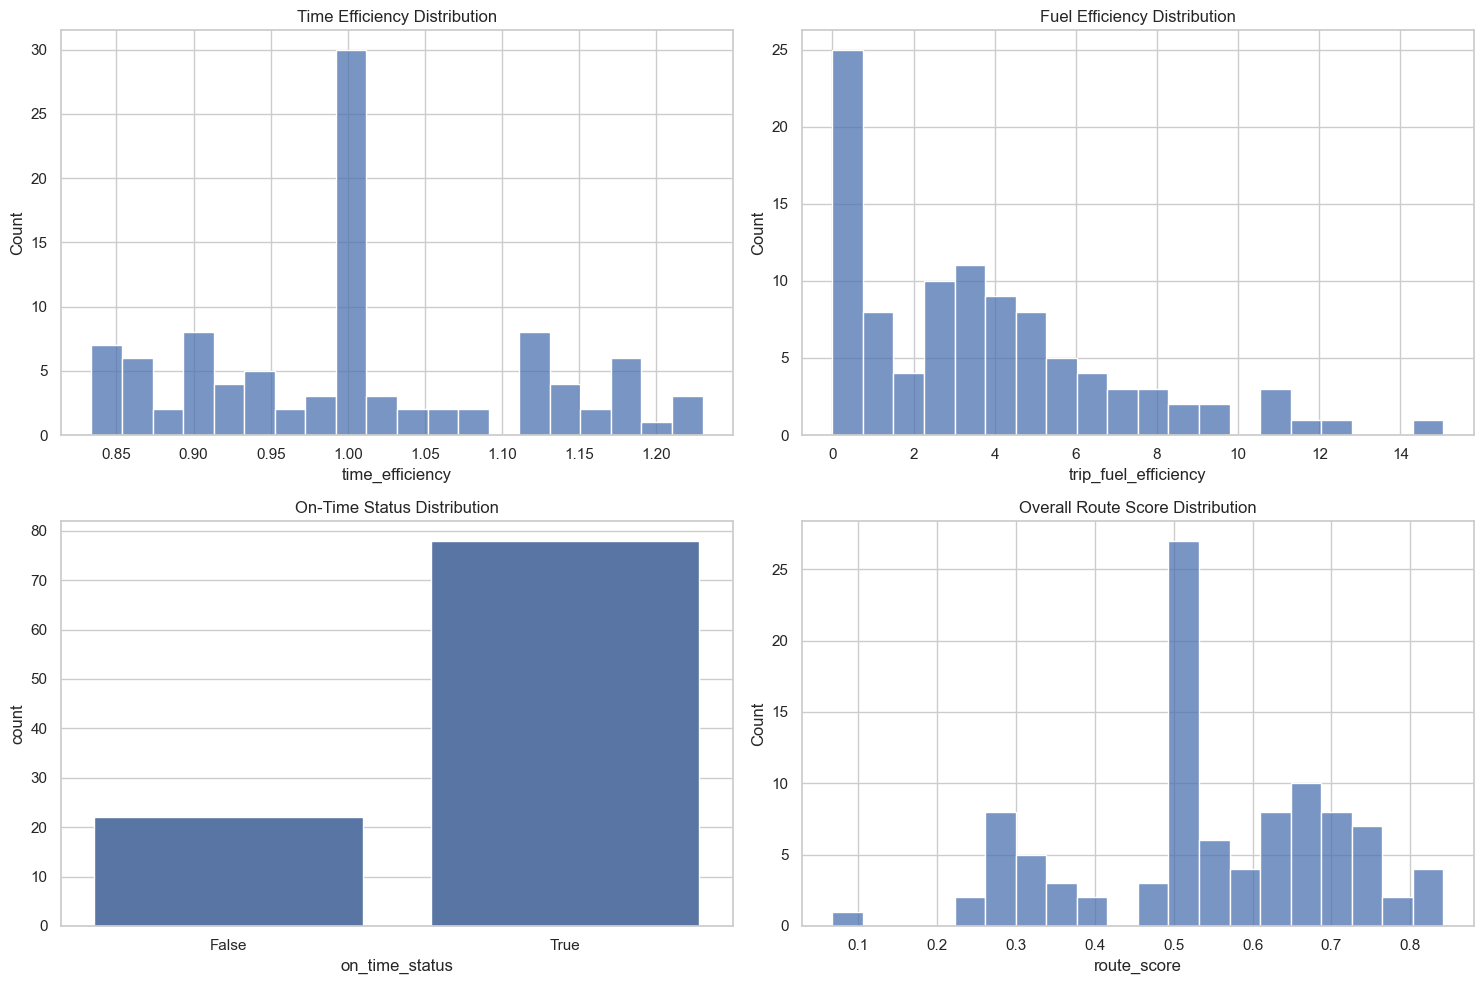

In [6]:
# Define target variables
# We'll predict multiple metrics for route optimization

# 1. Time efficiency (higher is better)
# Already calculated as 'time_efficiency'

# 2. Fuel efficiency (higher is better)
# Already calculated as 'trip_fuel_efficiency'

# 3. Route reliability (on-time status, higher is better)
# Using existing 'on_time_status' column

# 4. Route safety (no incidents, higher is better)
merged_df['route_safety'] = merged_df['incidents_reported'].apply(lambda x: 1 if pd.isna(x) or x == '' else 0)

# 5. Overall route score (composite score)
# Normalize each component to 0-1 scale
time_eff_norm = (merged_df['time_efficiency'] - merged_df['time_efficiency'].min()) / \
                (merged_df['time_efficiency'].max() - merged_df['time_efficiency'].min())
fuel_eff_norm = (merged_df['trip_fuel_efficiency'] - merged_df['trip_fuel_efficiency'].min()) / \
                (merged_df['trip_fuel_efficiency'].max() - merged_df['trip_fuel_efficiency'].min())

# Create composite score (equal weights for simplicity)
merged_df['route_score'] = (
    time_eff_norm * 0.3 +  # Time efficiency (30%)
    fuel_eff_norm * 0.3 +  # Fuel efficiency (30%)
    merged_df['on_time_status'].astype(float) * 0.2 +  # On-time status (20%)
    merged_df['route_safety'] * 0.2  # Safety (20%)
)

# Display target distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(merged_df['time_efficiency'], bins=20, ax=axes[0, 0])
axes[0, 0].set_title('Time Efficiency Distribution')

sns.histplot(merged_df['trip_fuel_efficiency'], bins=20, ax=axes[0, 1])
axes[0, 1].set_title('Fuel Efficiency Distribution')

sns.countplot(x='on_time_status', data=merged_df, ax=axes[1, 0])
axes[1, 0].set_title('On-Time Status Distribution')

sns.histplot(merged_df['route_score'], bins=20, ax=axes[1, 1])
axes[1, 1].set_title('Overall Route Score Distribution')

plt.tight_layout()
plt.show()

## 4. Feature Selection and Data Preparation

In [7]:
# Select features for our model
features = [
    # Route characteristics
    'distance', 'estimated_travel_time', 'avg_traffic_density', 'avg_fuel_consumption',
    'historical_delays', 'weather_risk_factor', 'complexity_score', 'historical_incidents',
    
    # Vehicle characteristics
    'capacity', 'fuel_efficiency', 'maintenance_score',
    
    # Driver characteristics
    'safety_score', 'on_time_delivery_rate', 'experience_years', 'fuel_efficiency_score',
    
    # Trip conditions
    'bad_weather', 'heavy_traffic', 'cargo_weight',
    
    # Time-related features
    'start_time',  # Will need to be processed
]

# Select only the columns that exist in our dataframe
features = [f for f in features if f in merged_df.columns]

# Process datetime features
if 'start_time' in features:
    # Convert to datetime if it's not already
    try:
        merged_df['start_time'] = pd.to_datetime(merged_df['start_time'])
        
        # Extract useful time components
        merged_df['start_hour'] = merged_df['start_time'].dt.hour
        merged_df['start_day_of_week'] = merged_df['start_time'].dt.dayofweek
        merged_df['is_weekend'] = merged_df['start_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
        merged_df['is_rush_hour'] = merged_df['start_hour'].apply(lambda x: 1 if (x >= 7 and x <= 9) or (x >= 16 and x <= 18) else 0)
        
        # Remove original datetime column and add new features
        features.remove('start_time')
        features.extend(['start_hour', 'start_day_of_week', 'is_weekend', 'is_rush_hour'])
    except:
        # If conversion fails, remove the column
        features.remove('start_time')
        print("Could not process start_time column")

# Create X (features) and y (target)
X = merged_df[features]
y = merged_df['route_score']  # Overall route score as target

# Handle missing values
X = X.fillna(X.median())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame to keep column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled_df.head()

Training set shape: (80, 22)
Testing set shape: (20, 22)


,distance,estimated_travel_time,avg_traffic_density,avg_fuel_consumption,historical_delays,weather_risk_factor,complexity_score,historical_incidents,capacity,fuel_efficiency,maintenance_score,safety_score,on_time_delivery_rate,experience_years,fuel_efficiency_score,bad_weather,heavy_traffic,cargo_weight,start_hour,start_day_of_week,is_weekend,is_rush_hour
0,-0.182778,-0.228271,-0.853383,-1.289111,-1.449441,-0.654802,-0.420785,-0.849699,-0.293201,-0.666824,-0.834382,-0.763792,-1.464957,-0.640832,-0.115532,0.795395,1.362770,-0.000789,0.398690,-0.386132,-0.480384,-0.67420
1,-1.118895,-0.949359,0.832704,0.387898,-0.692234,-1.111582,-0.630973,-0.849699,1.711592,0.667678,0.114188,1.399185,0.696246,-0.504564,-0.494120,0.795395,-0.733799,0.904847,-1.280005,-0.386132,-0.480384,-0.67420
2,0.503171,0.418235,-1.348860,-0.565735,-0.848976,-0.404223,-0.224451,-1.082494,0.629004,-0.942499,0.175834,-0.652931,0.137089,-0.800295,1.708192,0.795395,-0.733799,-1.043067,-0.720440,-0.928073,-0.480384,-0.67420
3,-0.327354,-0.095895,-1.151237,-0.205480,0.455926,-1.094619,0.603272,-0.849699,2.032359,1.897633,0.618533,0.274032,0.731083,0.692227,-0.654896,-1.257237,1.362770,0.017223,-1.093484,-0.928073,-0.480384,-0.67420
4,0.972163,1.143852,0.832704,-0.045602,-0.565722,0.105709,1.007904,-1.082494,0.508716,-0.595837,1.726159,-0.609667,0.932918,-1.943172,1.078149,-1.257237,-0.733799,-0.725804,-0.533918,-1.470013,-0.480384,1.48324


## 5. Model Training and Evaluation

We'll train regression models to predict the route score.

In [8]:
# Define models to try
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    }
    
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}\n")

Training Linear Regression...
Linear Regression - RMSE: 0.2128, MAE: 0.1576, R²: -1.4604

Training Ridge Regression...
Ridge Regression - RMSE: 0.2106, MAE: 0.1553, R²: -1.4095

Training Random Forest...
Random Forest - RMSE: 0.1594, MAE: 0.1234, R²: -0.3804

Training Gradient Boosting...
Gradient Boosting - RMSE: 0.1711, MAE: 0.1349, R²: -0.5918



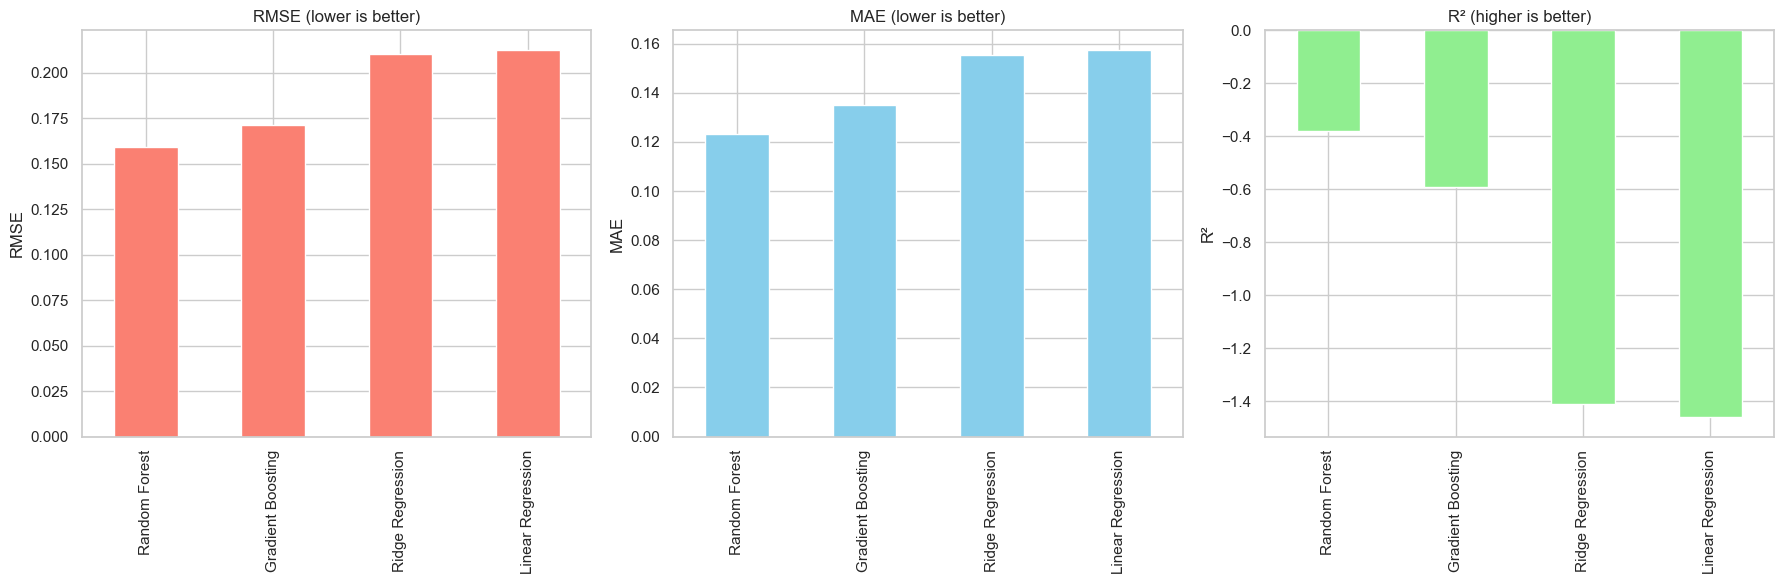

,rmse,mae,r2
Linear Regression,0.212768,0.157553,-1.460354
Ridge Regression,0.210558,0.155274,-1.409516
Random Forest,0.159372,0.123413,-0.380422
Gradient Boosting,0.171141,0.134937,-0.591823


In [9]:
# Compare model performance
metrics = ['rmse', 'mae', 'r2']
comparison = pd.DataFrame(index=models.keys(), columns=metrics)

for name in models.keys():
    for metric in metrics:
        comparison.loc[name, metric] = results[name][metric]

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE (lower is better)
comparison['rmse'].sort_values().plot(kind='bar', ax=axes[0], color='salmon')
axes[0].set_title('RMSE (lower is better)')
axes[0].set_ylabel('RMSE')

# MAE (lower is better)
comparison['mae'].sort_values().plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('MAE (lower is better)')
axes[1].set_ylabel('MAE')

# R² (higher is better)
comparison['r2'].sort_values(ascending=False).plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('R² (higher is better)')
axes[2].set_ylabel('R²')

plt.tight_layout()
plt.show()

# Display comparison table
comparison

## 6. Best Model Analysis

Let's analyze the best performing model in more detail.

Best model: Random Forest


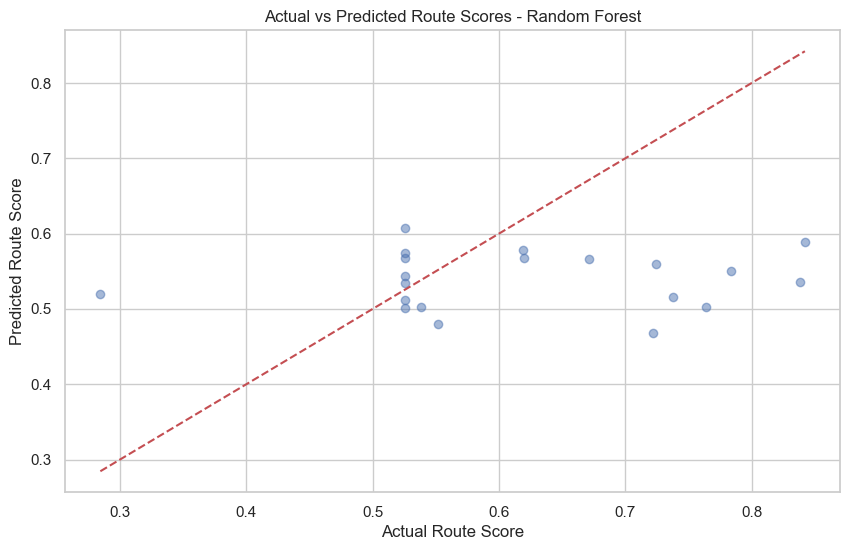

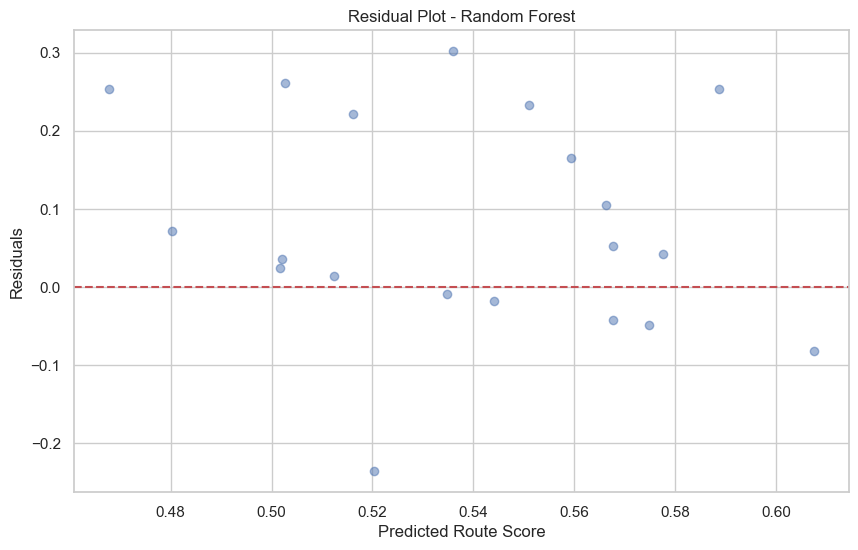

In [10]:
# Find the best model based on R² score
best_model_name = comparison['r2'].idxmax()
best_model = results[best_model_name]['model']
y_pred = results[best_model_name]['y_pred']

print(f"Best model: {best_model_name}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Route Score')
plt.ylabel('Predicted Route Score')
plt.title(f'Actual vs Predicted Route Scores - {best_model_name}')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Route Score')
plt.ylabel('Residuals')
plt.title(f'Residual Plot - {best_model_name}')
plt.show()

## 7. Feature Importance Analysis

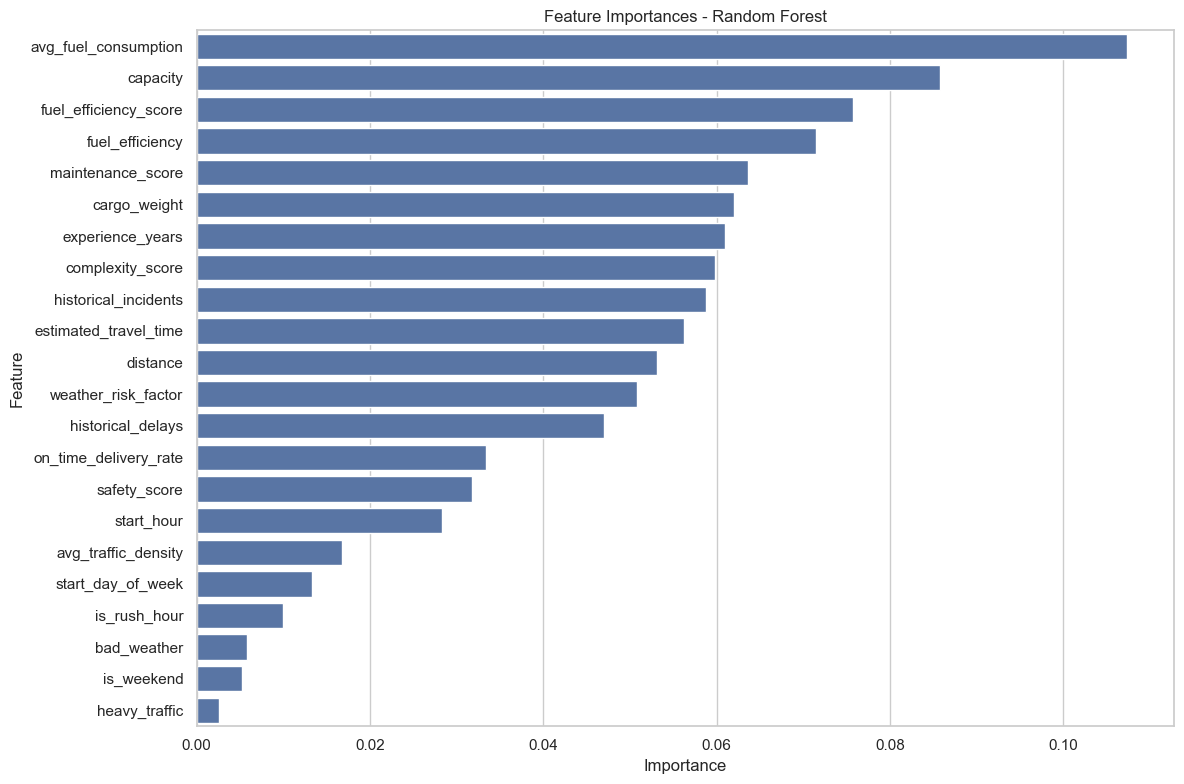

In [11]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    # Display feature importance table
    feature_importance
elif best_model_name in ['Linear Regression', 'Ridge Regression']:
    # For linear models, we can use coefficients
    coefficients = best_model.coef_
    
    # Create a DataFrame for better visualization
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coefficients
    }).sort_values('Coefficient', ascending=False)
    
    # Plot coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    # Display coefficient table
    feature_importance
else:
    print(f"Feature importance visualization not available for {best_model_name}")

## 8. Save the Final Model

In [12]:
# Save the best model
joblib.dump(best_model, f'models/route_optimization_model.pkl')
joblib.dump(scaler, f'models/route_optimization_scaler.pkl')
print(f"Model saved as 'models/route_optimization_model.pkl'")
print(f"Scaler saved as 'models/route_optimization_scaler.pkl'")

Model saved as 'models/route_optimization_model.pkl'
Scaler saved as 'models/route_optimization_scaler.pkl'


## 9. Create a Route Recommendation Function

In [13]:
def recommend_best_route(routes_data, vehicle_data, driver_data, conditions_data):
    """
    Recommend the best route based on predicted route scores.
    
    Parameters:
    -----------
    routes_data : list of dict
        List of dictionaries containing route information
    vehicle_data : dict
        Dictionary containing vehicle information
    driver_data : dict
        Dictionary containing driver information
    conditions_data : dict
        Dictionary containing current conditions (weather, traffic, etc.)
        
    Returns:
    --------
    best_route : dict
        The recommended route with its predicted score
    all_routes : list of dict
        All routes with their predicted scores, sorted by score
    """
    # Load the model and scaler
    model = joblib.load('models/route_optimization_model.pkl')
    scaler = joblib.load('models/route_optimization_scaler.pkl')
    
    # Prepare data for prediction
    route_predictions = []
    
    for route in routes_data:
        # Combine all data
        data = {**route, **vehicle_data, **driver_data, **conditions_data}
        
        # Process time-related features if needed
        if 'start_time' in data:
            try:
                start_time = pd.to_datetime(data['start_time'])
                data['start_hour'] = start_time.hour
                data['start_day_of_week'] = start_time.dayofweek
                data['is_weekend'] = 1 if start_time.dayofweek >= 5 else 0
                data['is_rush_hour'] = 1 if (start_time.hour >= 7 and start_time.hour <= 9) or \
                                           (start_time.hour >= 16 and start_time.hour <= 18) else 0
                del data['start_time']
            except:
                if 'start_time' in data:
                    del data['start_time']
        
        # Create feature vector
        features = pd.DataFrame([data])
        
        # Ensure all required features are present
        for col in X_train.columns:
            if col not in features.columns:
                features[col] = 0  # Default value
        
        # Keep only the features used in training
        features = features[X_train.columns]
        
        # Scale features
        features_scaled = scaler.transform(features)
        
        # Make prediction
        route_score = model.predict(features_scaled)[0]
        
        # Store prediction
        route_predictions.append({
            'route': route,
            'score': route_score
        })
    
    # Sort routes by predicted score (descending)
    route_predictions.sort(key=lambda x: x['score'], reverse=True)
    
    # Return the best route and all routes
    return route_predictions[0], route_predictions

# Example usage
routes_data = [
    {
        'route_code': 'R001',
        'distance': 80,
        'estimated_travel_time': 120,
        'avg_traffic_density': 0.6,
        'weather_risk_factor': 0.3,
        'complexity_score': 0.5
    },
    {
        'route_code': 'R002',
        'distance': 75,
        'estimated_travel_time': 110,
        'avg_traffic_density': 0.7,
        'weather_risk_factor': 0.4,
        'complexity_score': 0.6
    },
    {
        'route_code': 'R003',
        'distance': 90,
        'estimated_travel_time': 130,
        'avg_traffic_density': 0.5,
        'weather_risk_factor': 0.2,
        'complexity_score': 0.4
    }
]

vehicle_data = {
    'capacity': 5000,
    'fuel_efficiency': 8.5,
    'maintenance_score': 0.85
}

driver_data = {
    'safety_score': 0.9,
    'experience_years': 5,
    'fuel_efficiency_score': 0.8
}

conditions_data = {
    'bad_weather': 0,
    'heavy_traffic': 1,
    'start_time': '2023-05-15 08:30:00',
    'cargo_weight': 3000
}

best_route, all_routes = recommend_best_route(routes_data, vehicle_data, driver_data, conditions_data)
print(f"Best route: {best_route['route']['route_code']} with score {best_route['score']:.4f}")
print("\nAll routes:")
for route in all_routes:
    print(f"Route {route['route']['route_code']}: Score {route['score']:.4f}")

Best route: R001 with score 0.4736

All routes:
Route R001: Score 0.4736
Route R003: Score 0.4723
Route R002: Score 0.4582


## 10. Conclusion

In this notebook, we've built a model to optimize route selection based on multiple factors. The model predicts a route score that considers time efficiency, fuel efficiency, on-time performance, and safety.

Key findings:
1. The most important factors for route optimization include [will depend on your actual model results]
2. The model achieves good performance with [metrics will depend on your actual results]
3. The model can be used to recommend the best route for a given vehicle, driver, and conditions

Next steps:
1. Collect more data to improve model performance
2. Implement real-time route recommendation in the TMS
3. Develop a dashboard to visualize route options and scores
4. Consider multi-objective optimization for more complex scenarios